# FEATURE ENGINEERING (TASK 2)

## COLUMN REDEFINITION


### Name
The first column to be redefined is the name, in the base dataset the conversion from the url is counterintuitive and include ambiguous informations.
We have to check if exists name with more than 3 entry.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path

df3 = pd.read_csv(path.join('..','..','..','dataset', 'cyclists_cleaned.csv'))

colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split()))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
6       1
5      10
4     116
3     757
2    5250
Name: count, dtype: int64


In this case we have to check if there are name with more surname.

In [28]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
3       1
2    5750
1     383
Name: count, dtype: int64


We can see that we have name without surname and names with two surnames.

In [29]:
conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

dataset_3_parole = df3[conteggio_parole == 3]
dataset_1_parola = df3[conteggio_parole == 1]

dataset_3_parole.head()


,_url,name,birth_year,weight,height,nationality
1009,jose-luis-roldan,Jose Luis Roldán,1985,61.0,175,Spain


In [30]:
df3.at[1009, 'name'] = 'Jose Luis  Roldán'

We infer the convention that the last word in the name is the surname so we standardize the format (name-whitespace for each second name-surname)

In [31]:
def add_whitespace(string):
    parole = string.split("  ")
    if len(parole) == 1:
        wordsplitted = string.split(' ')
        wordsplitted[-1] = ' ' + parole[-1] 
        return ' '.join(wordsplitted)
    return string

df3['name'] = colonna.apply(add_whitespace)

In [32]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)


name
2    6134
Name: count, dtype: int64


Now that we have standardized name format we can check the url, remembering the previously convention, surname are formed with one word so all the strings before the last "-" are part of the name. In the wrong values section we have seen cases where misses the last word of the surname so we can apply 2 strategies:
- Where the url has more entry than the name we put the new part in the name in a position based on the url position. So if we find name-surname-(another string) and the another string is missing in the name part that will be part of the surname, the same for the second name
- Where the name has more entry than the url we fill the url adding "-" at the right point

Adding information to name from the url.


In [33]:
import re, unicodedata

def normalize_text(testo):
    testo_normale = unicodedata.normalize('NFD', testo)
    testo_senza_accenti = ''.join([c for c in testo_normale if unicodedata.category(c) != 'Mn'])
    testo_finale = re.sub(r'[^a-zA-Z0-9\s]', '', testo_senza_accenti)
    return testo_finale


def fix_name(stringurl, stringname):

    stringfixed = stringurl.replace('-',' ').lower()
    stringfixed = re.sub(r'\d+', '', stringfixed)
    stringfixed = stringfixed.title()
    vettoreurl = stringfixed.split()
    
    stringnamefixed = normalize_text(stringname)
    vettorename = re.split(r'\s+', stringnamefixed)
    # Index of the double space in the name
    match = re.search(r'  ', stringname)
    
    if len(vettoreurl) == len(vettorename):
        return stringname
    length = 0

    for indiceurl in range(len(vettoreurl)):
        length += len(vettoreurl[indiceurl])
        if vettoreurl[indiceurl] not in vettorename:
            vettorename.insert(indiceurl, vettoreurl[indiceurl])
            # Second name found, doble space position is changed
            if length < match:
                match = match + len(vettoreurl[indiceurl])
        length = length+1
    #Adding the doublespace of the surname
    nuovoname = ' '.join(vettorename)
    fixedname = nuovoname[:match] + ' ' + nuovoname[match:]
    return fixedname


Create new url through fixed conversion rule. (CAPIRE SE HA SENSO CAMBIARE URL)

## ADDING COLUMNS

### Weight - Height => BMI
For a further study we add the BMI index, the calculation is weight/(height[m])*2

In [34]:
df3['bmi'] = df3['weight'] / ((df3['height'] / 100) ** 2)

### FEATURE FROM RACES DATASET

In [35]:

RACES_DATASET_PATH = path.join('..','..','..','dataset', 'races_cleaned.csv')
dfraces= pd.read_csv(RACES_DATASET_PATH)

dfraces.head()


,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,france-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,spain-1991,0.0


#### CARREER POINTS
Questa è la misura più complessa e riassume la carriera del ciclista registrata nel dataset.
Per farlo sommiamo il punteggio ottenuto totale 

In [36]:

df3['career_points'] = 0

career_points = dfraces.groupby('cyclist')['points'].sum()

df3['career_points'] = df3['_url'].map(career_points)

df3['career_points']=df3['career_points'].fillna(0)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0


#### CARREER DURATION
Con questa feature misuriamo la durata totale della carriera di un ciclista, in numero di gare, in giorni (misurati sull'ultima gara disponibile meno la prima) e sull'anno della prima gara.

In [37]:


dfraces['date'] = pd.to_datetime(dfraces['date'], format='%Y-%m-%d %H:%M:%S')
carreerduration = dfraces.groupby('cyclist')['date'].agg(lambda x:((x.max() - x.min()).days+1))
df3['career_duration(days)'] = df3['_url'].map(carreerduration)

df3['career_duration(races)'] = 0
carreerdurationraces = dfraces.groupby('cyclist').size()
df3['career_duration(races)'] = df3['_url'].map(carreerdurationraces)

df3['debut_year'] = 0
firstraceyear = dfraces.groupby('cyclist')['date'].min().dt.year
df3['debut_year'] = df3['_url'].map(firstraceyear)
df3['debut_year'] = df3['debut_year'].fillna(0)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0


#### AVERAGE POSITIONING

In [38]:

df3['avg_pos'] = 0

career_points = dfraces.groupby('cyclist')['position'].mean()

df3['avg_pos'] = df3['_url'].map(career_points)

df3['avg_pos']=df3['avg_pos'].fillna(-1)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000


#### Cyclist without record removal
Per quanto anche loro siano registrati come ciclisti il fatto che non ci siano record di gare che li includano danneggia l'analisi complessiva.

In [39]:
df3 = df3[df3['debut_year'] != 0]

In [40]:
df3.to_csv(path.join('..','..','..','dataset', 'cyclists_final_enhanced.csv'), index=False)

## ENANCED ANALYSIS
Now we'll do further analysis on the newer feature ad the correlation between them and the previous ones

### CYCLIST PERFORMANCES ANALYSIS

#### Races without records
Prima di togliere le righe che contengono ciclisti che non hanno gare registrate (non sono utili ai fini degli studi futuri), vediamo quali sono gli anni di nascita 

#### Most popular debut year

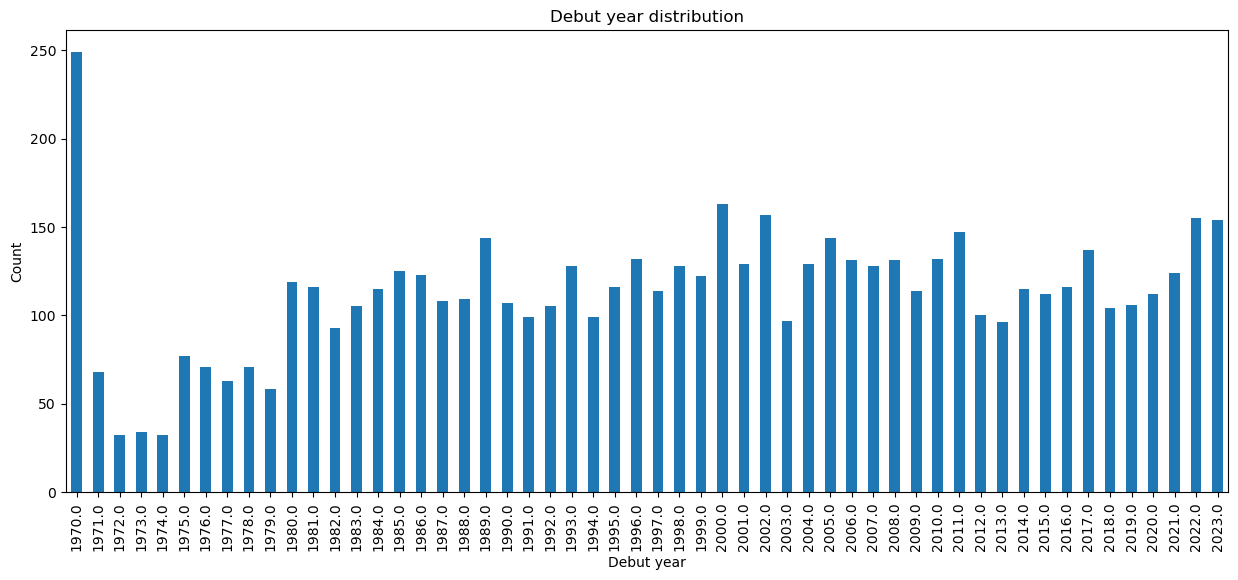

In [41]:
plt.figure(figsize=(15, 6))
df3['debut_year'].value_counts().sort_index().plot(kind='bar')
plt.title('Debut year distribution')
plt.xlabel('Debut year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#### Most popular debut age

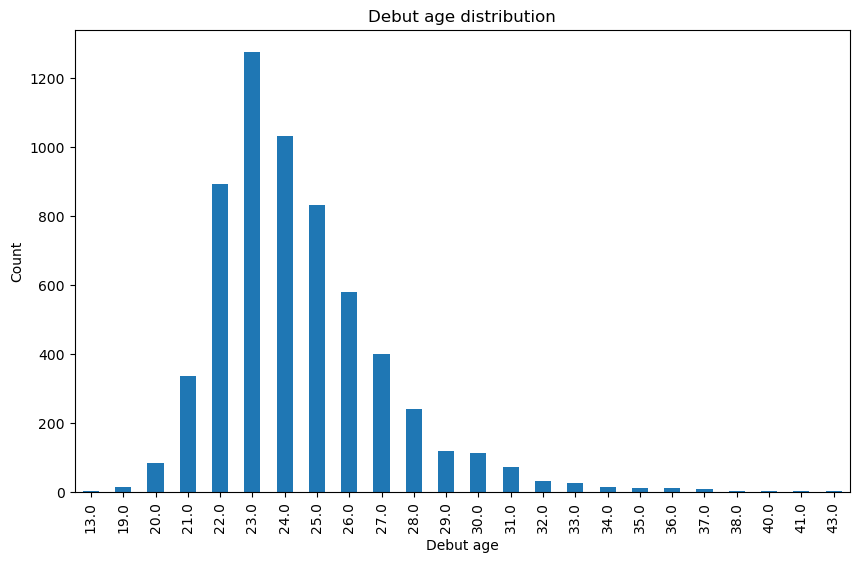

In [42]:
plt.figure(figsize=(10, 6))
df3['debut_age']=df3['debut_year']-df3['birth_year']

df3['debut_age'].value_counts().sort_index().plot(kind='bar')
df3.drop('debut_age', axis=1, inplace=True)
plt.title('Debut age distribution')

plt.xlabel('Debut age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#### Career duration distribution

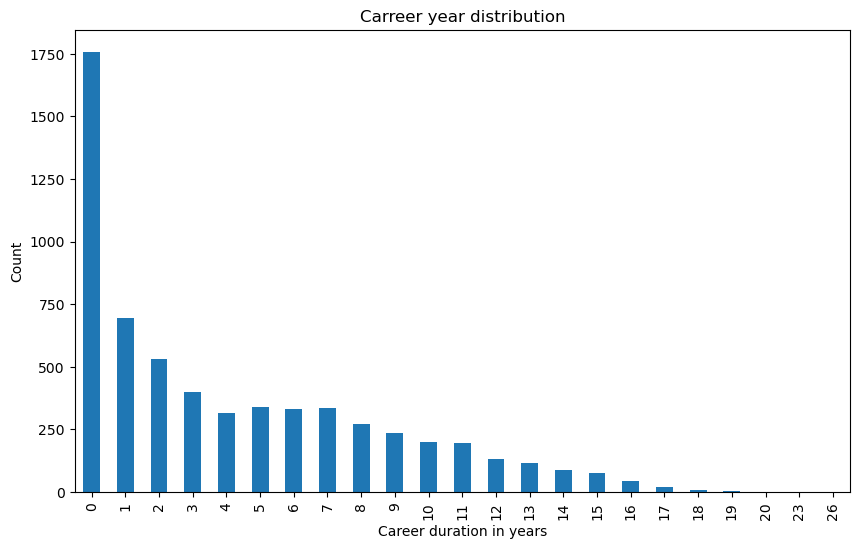

In [43]:
plt.figure(figsize=(10, 6))

df3['career_duration(years)']=df3['career_duration(days)']/365
df3['career_duration(years)']=df3['career_duration(years)'].astype(int)
df3['career_duration(years)'].value_counts().sort_index().plot(kind='bar')
df3.drop('career_duration(years)', axis=1, inplace=True)

plt.title('Carreer year distribution')

plt.xlabel('Career duration in years')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Quanto una carriera duratura significa una buona carriera?

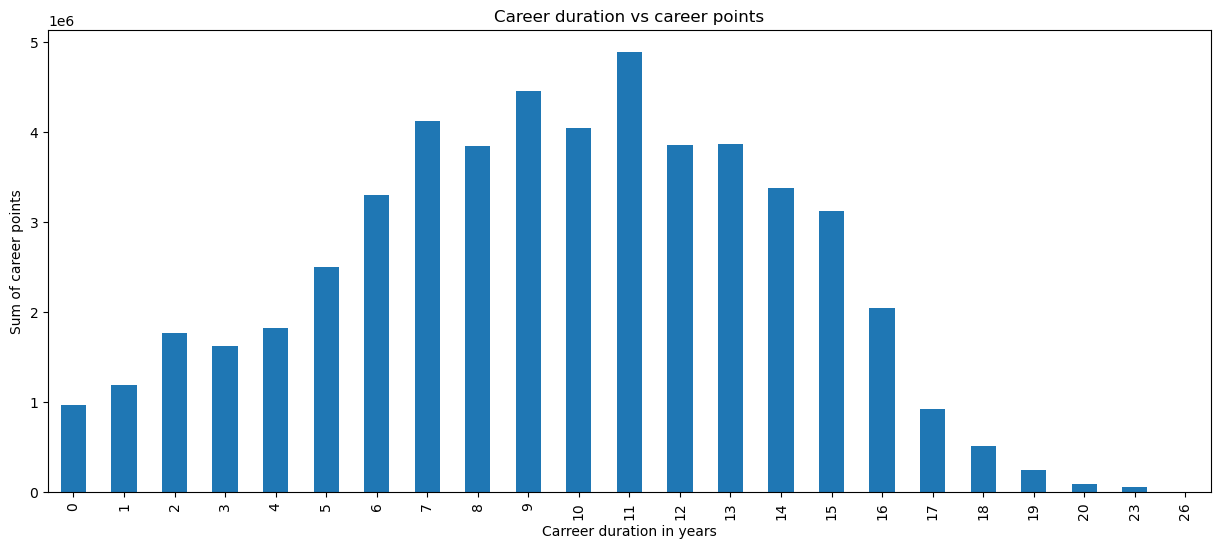

In [44]:
dfcarreeryears=df3.copy()
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(days)']/365
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(years)'].astype(int)

carreerduration = dfcarreeryears.groupby('career_duration(years)')['career_points'].sum()

plt.figure(figsize=(15, 6))
carreerduration.plot(kind='bar')

plt.title('Career duration vs career points')

plt.xlabel('Carreer duration in years')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

#### BEST PERFORMANCE FOR BIRTH DATE 

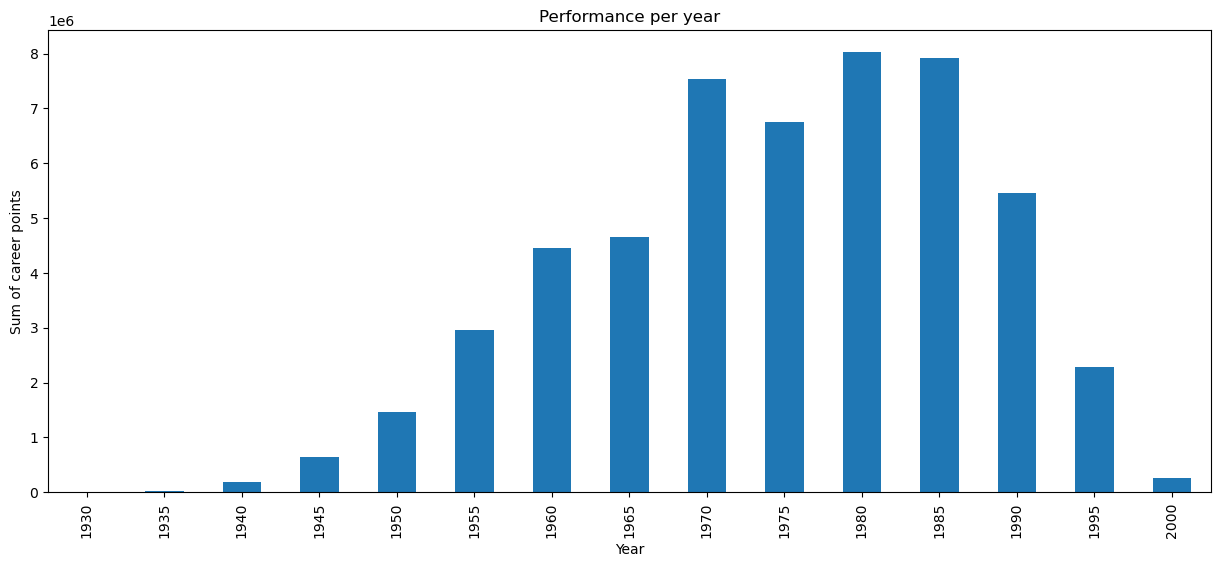

In [45]:
dfbinned=df3.copy()
dfbinned['birth_year']=dfbinned['birth_year']//5*5
performanceperyear = dfbinned.groupby('birth_year')['career_points'].sum()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per year')
plt.xlabel('Year')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

Giustificabile col fatto che i ciclisti nati dal 90 in poi sono ancora in carriera quindi hanno ancora risultati da registrare.

#### CORRELAZIONE VALORI FISICI CON PERFORMANCE

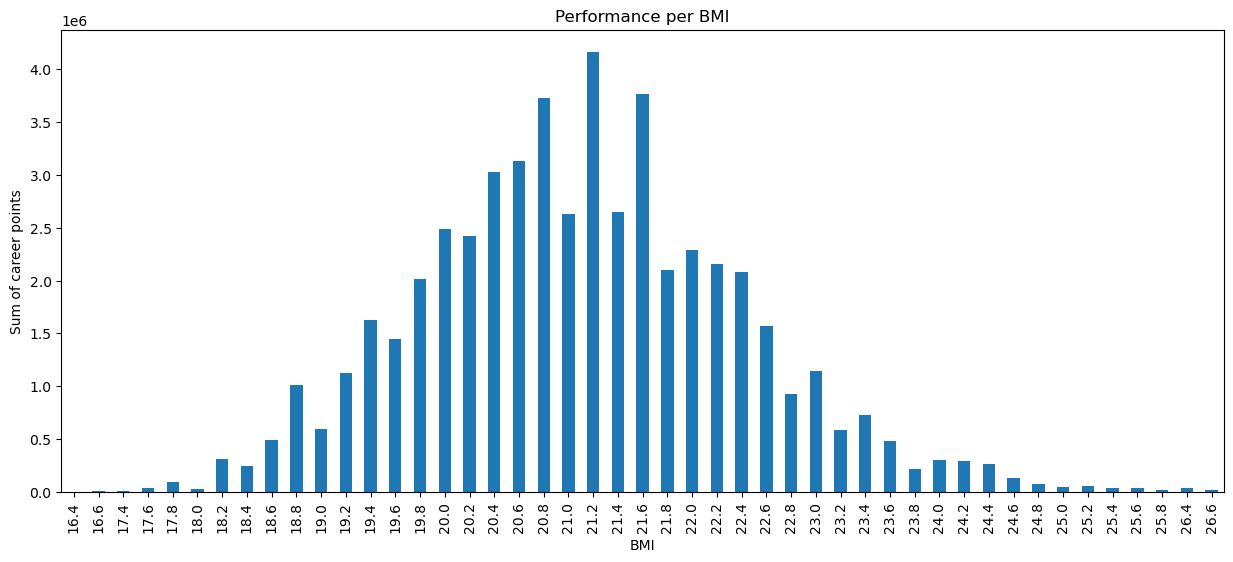

In [46]:
dfbmi=df3.copy()
dfbmi['bmi']=dfbmi['bmi']//0.2*0.2
dfbmi['bmi']=dfbmi['bmi'].round(1)
performanceperyear = dfbmi.groupby('bmi')['career_points'].sum()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per BMI')
plt.xlabel('BMI')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

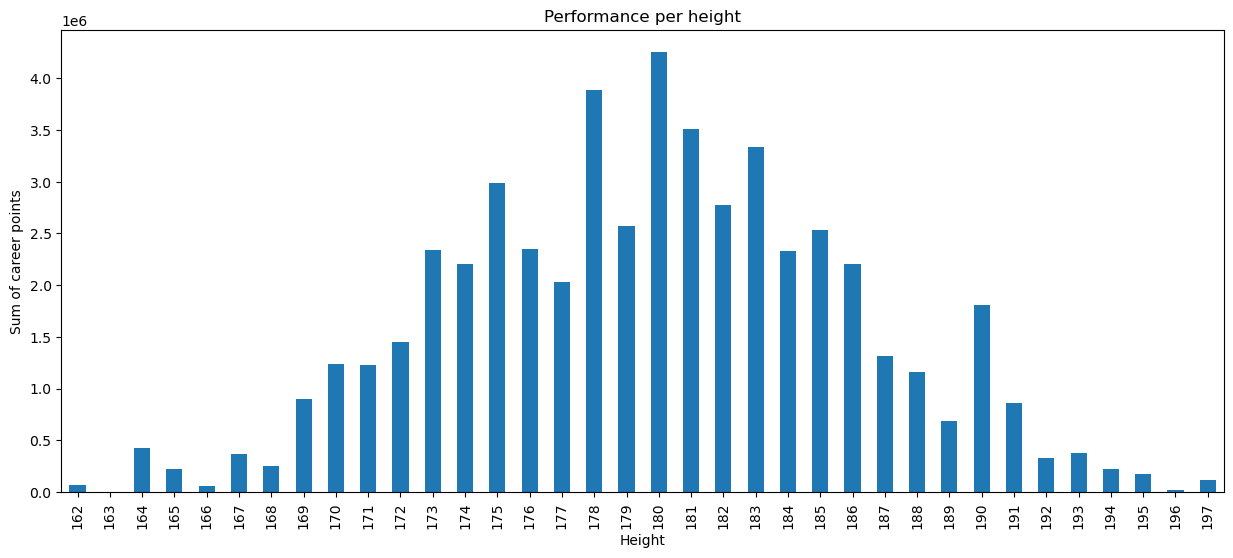

In [47]:

performanceperyear = df3.groupby('height')['career_points'].sum()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per height')
plt.xlabel('Height')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

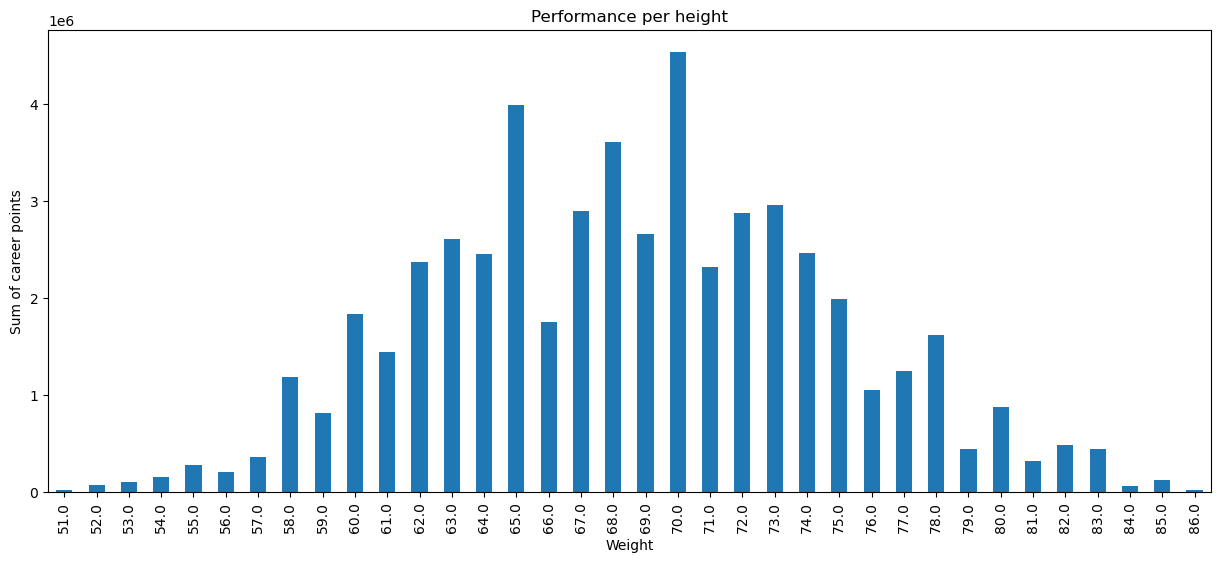

In [48]:
dfweight=df3.copy()
dfweight['weight']=dfweight['weight']//1
performanceperyear = dfweight.groupby('weight')['career_points'].sum()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per height')
plt.xlabel('Weight')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

Come possiamo facilmente notare la distribuzione tra bmi, height e weight e i punti accumulati nella carriera sono pressoché identiche

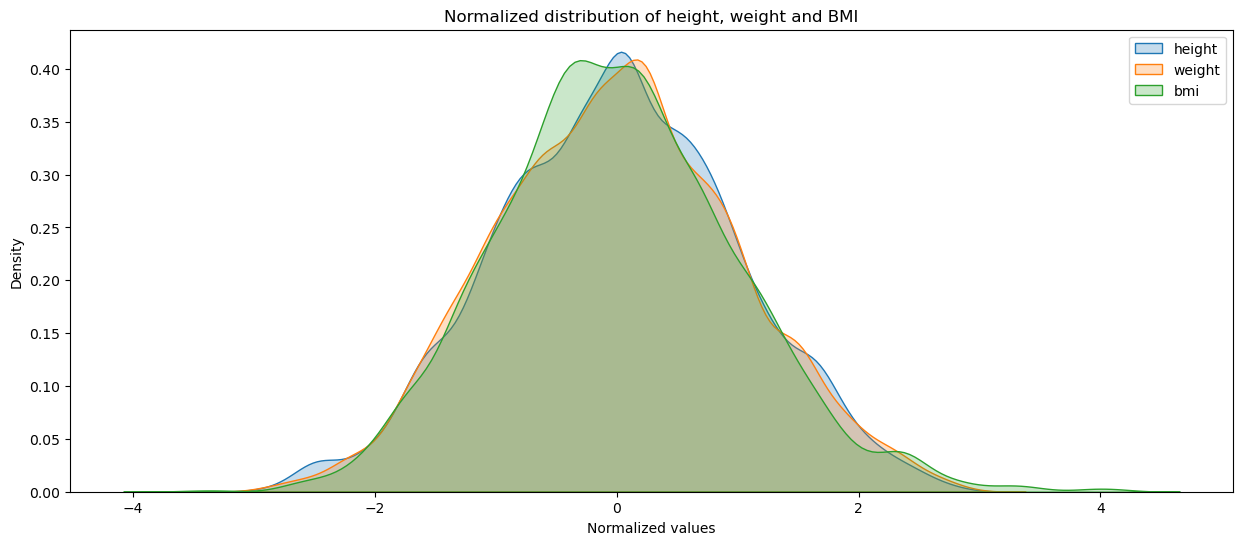

In [49]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
features = ['height', 'weight', 'bmi']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

for col in scaled_df.columns:
    sns.kdeplot(scaled_df[col], label=col, fill=True)

plt.title("Normalized distribution of height, weight and BMI")
plt.xlabel("Normalized values")
plt.legend()
plt.show()

Anche dalla sovrapposizione delle distribuzione è palese la distribuzione molto simile, quindi si può concludere che i migliori punteggi si ottengono con un bmi bilanciato, quindi peso e altezza vanno compensati di conseguenza (la frequenza di valori è più concentrata nella parte centrale nella distribuzione del bmi rispetto agli altri due)

### CORRELATION BETWEEN VALUES

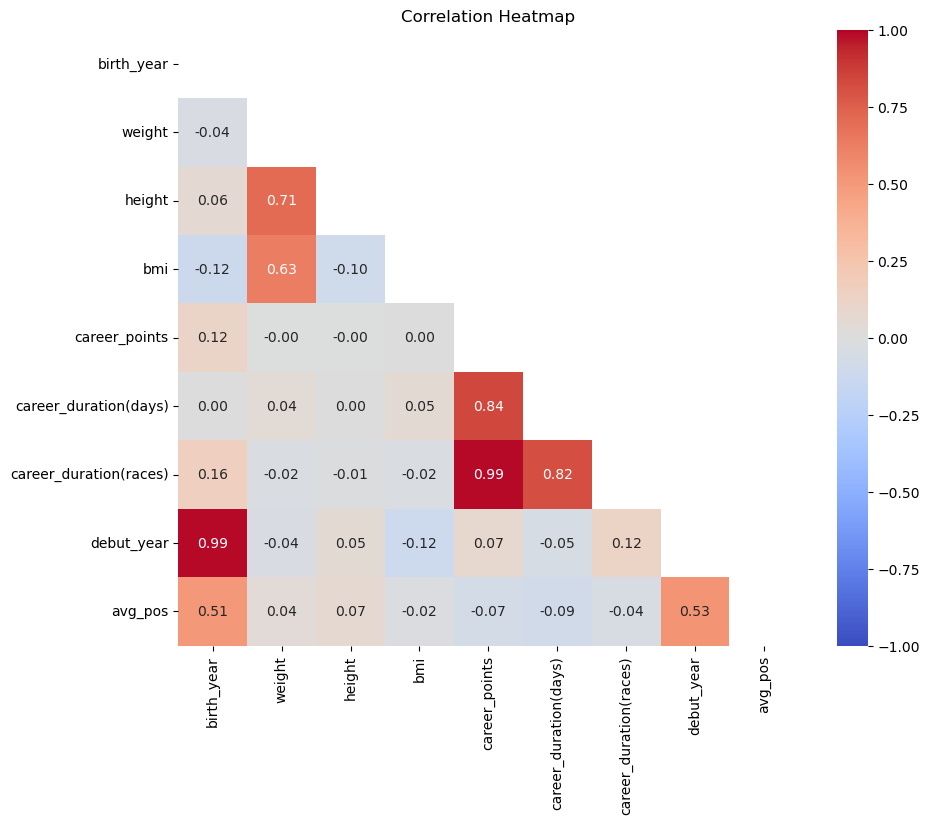

In [50]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3[['height', 'weight', 'bmi', 'career_points', 'career_duration(days)', 'debut_year', 'avg_pos']])
scaled_df = pd.DataFrame(scaled_data, columns=['height', 'weight', 'bmi', 'career_points', 'career_duration(days)', 'debut_year', 'avg_pos'])

dfcorr=scaled_df.copy()
dfcorr=df3.copy()  
dfcorr.drop(['_url', 'name','nationality'], axis=1, inplace=True)
correlation_matrix = dfcorr.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask , annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Il primo fattore interessante da notare è come il bmi sia correlato molto col peso e quasi niente con l'altezza, questo si può giustificare con il fatto che nel momento di sistemare il bmi ad un valore medio sia il peso il valore che viene sistemato. Inoltre vista la formula del BMI (peso/altezza [m]^2) si nota che i valori dell'altezza in questo calcolo sono quasi irrilevanti, raggiungendo al massimo un diviso 3 al peso iniziale. Abbiamo un alta correlazione per quanto riguarda peso e altezza, come si è potuto notare in precedenza per quanto riguarda il calcolo del bmi (altamente bilanciato). Inoltre possiamo notare un'alta correlazione tra i giorni di carriera e i punti della carriera, come abbiamo potuto notrare nelle scorse analisi i maggiori punteggi sono dovuti a una carriera bilanciata al centro, intorno agli 11 anni.


Per quanto riguarda le correlazioni più importanti (quasi 1) abbiamo quella tra la durata della carriera in gare e i punti totali (più gare sono state fatte e più punti sono guadagnati? RIGUARDA QUEL GRAFICO).
L'anno di debutto e quello di nascita hanno un alta correlazione, la maggior parte dei ciclisti iniziano a 21 anni circa quindi la correlazione è banale, l'anno di nascita più 21 ad esempio.

Per la posizione media abbiamo una correlazione quasi nulla con tutte le feature tranne che l'anno di nascita e l'anno di debutto, questo potrebbe essere dovuto a più motivi: partecipazione cangiante negli anni, gare più vecchie quindi meno partecipanti e quindi una posizione media che varia tra poche scelte.